Downloading the zipped file using CurlWidget chrome extention.

In [13]:
!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,hi-IN;q=0.8,hi;q=0.7,ta-IN;q=0.6,ta;q=0.5,en-GB;q=0.4,en-US;q=0.3" --header="Cookie: __utmz=3028652.1624856291.2.2.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utma=3028652.1813042570.1624856084.1624856291.1624950891.3" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

--2021-07-07 06:12:02--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Extracting content from the zipped file

In [14]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "ita-eng.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')
del zip

File Name                                             Modified             Size
ita.txt                                        2021-06-21 00:59:38     49950514
_about.txt                                     2021-06-21 00:59:38         1441
Extracting all the files now...
Done!


In [15]:
import os
lines = open(os.getcwd() + '/ita.txt', encoding='utf-8').read().split('\n')   # Reading text file
print(f'No of lines: {len(lines)}')

No of lines: 350361


In [16]:
# Let's print few lines
print(lines[0])
print(lines[800])

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
I talked.	Parlai.	CC-BY 2.0 (France) Attribution: tatoeba.org #5828639 (CK) & #6104647 (Guybrush88)


There are a lot of unwanted text in each line. Formulate into a proper sentence.

In [17]:
# Configuration
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [18]:
import re

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for line in lines[:num_samples]:
    input_text, target_text = line.split("\t")[0], line.split("\t")[1]

    input_text = re.sub(r'[^\w\s]', '', input_text)  # Removing unwanted characters like punctuation marks
    input_text = re.sub(" \d+", " ", input_text)  # Removing digits
    input_text = re.sub(' +', ' ', input_text)  # Remoing extra white spaces
    input_text = input_text.lower()  # Converting to lower case

    target_text = re.sub(r'[^\w\s]', '', target_text)
    target_text = re.sub(" \d+", " ", target_text)
    target_text = re.sub(' +', ' ', target_text)
    target_text = target_text.lower()
    target_text = "\t" + target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [19]:
# Let's have a look at ceaned data
print(input_texts[0],'-->',target_texts[0])
print(input_texts[800],'-->',target_texts[800])

hi --> 	ciao

i talked --> 	parlai



In [20]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Input characters (English)", input_characters)
print("Target characters (Italian)", target_characters)
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Input characters (English) [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Target characters (Italian) ['\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'è', 'é', 'ì', 'ò', 'ù']
Number of samples: 10000
Number of unique input tokens: 27
Number of unique output tokens: 35
Max sequence length for inputs: 12
Max sequence length for outputs: 44


In [21]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

print("Input token index: ", input_token_index)
print("Target token index: ", target_token_index)

Input token index:  {' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Target token index:  {'\t': 0, '\n': 1, ' ': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, 'à': 29, 'è': 30, 'é': 31, 'ì': 32, 'ò': 33, 'ù': 34}


In [22]:
import numpy as np
encoder_input_data = np.zeros(shape=(num_samples, max_encoder_seq_length, num_encoder_tokens), dtype="float32")  # 10000 matrices of size 12 X 27
decoder_input_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32")  # 10000 matrices of size 44 X 35
decoder_target_data = np.zeros(shape=(num_samples, max_decoder_seq_length, num_decoder_tokens), dtype="float32") # 10000 matrices of size 44 X 35

This is a 12 X 27 matrix initialized with zero values
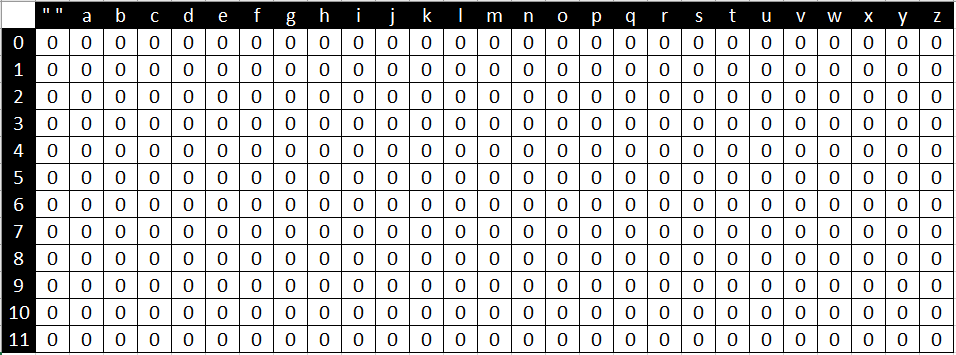

In [27]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):    # Traversing over each sentence
    for t, char in enumerate(input_text):                                         # Traversing over each character in a sentence
        encoder_input_data[i, t, input_token_index[char]] = 1.0                   # Based on input token dictionary it will assign the value 1 in the respective index
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0                  # For remaining rows, value 1 will be assined corresponding to blank value/empty string
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0                  # Based on input token dictionary it will assign the value 1 in the respective index
        if t > 0:                                                                 # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0         
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0                 # For remaining rows, value 1 will be assined corresponding to blank value/empty string
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0                     # For remaining rows, value 1 will be assined corresponding to blank value/empty string

<br>Input Sentence Representation: "hi"<br>
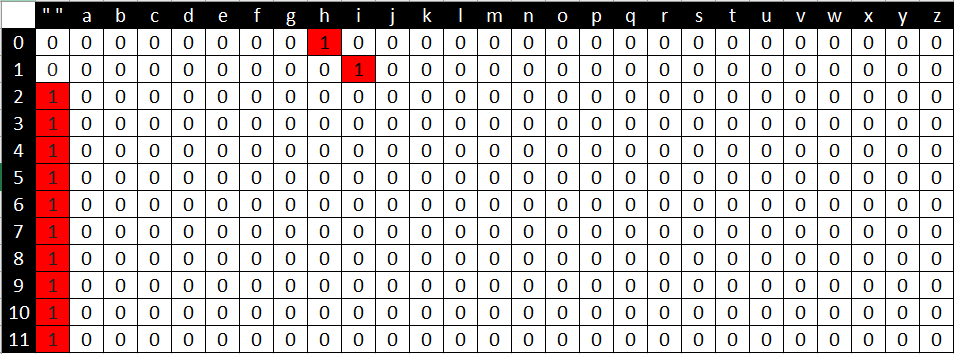
<br>Input Sentence Representation: "i talked"<br>
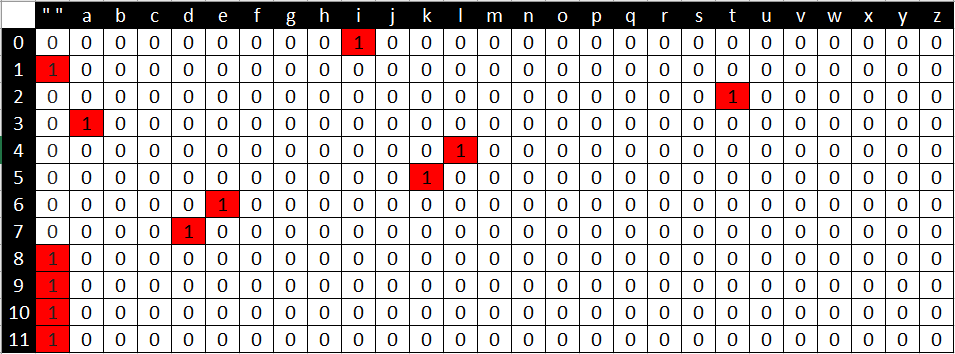
<br>Target Decoder Input:"\tciao\n"<br>
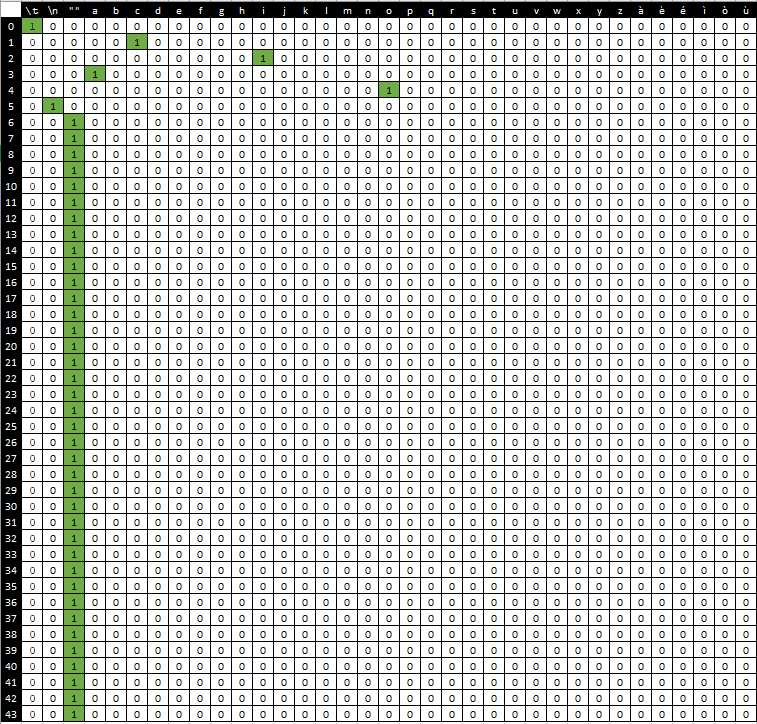<br>
<br>Target Decoder Input:"\tparlai\n"<br>
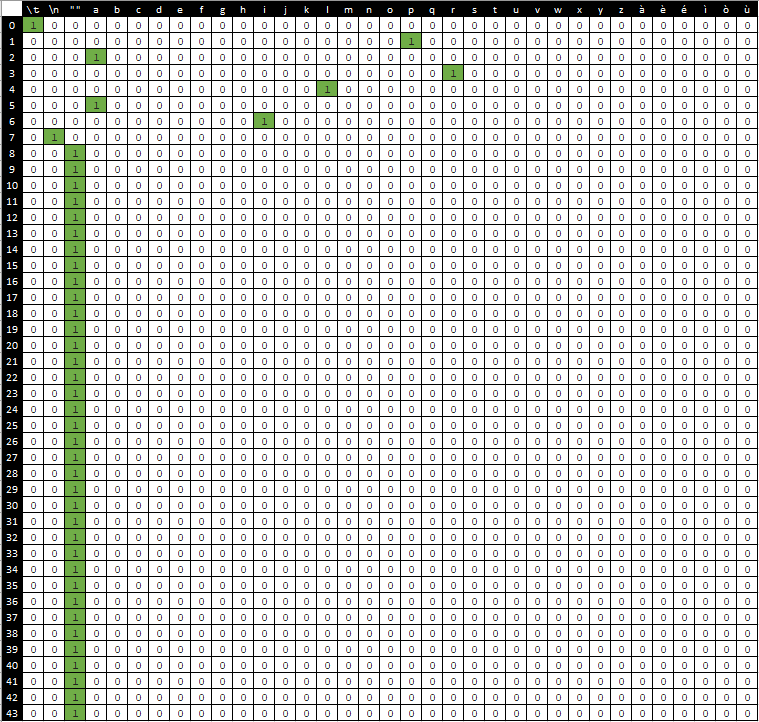
<br>Target Decoder Input:"ciao\n"<br>
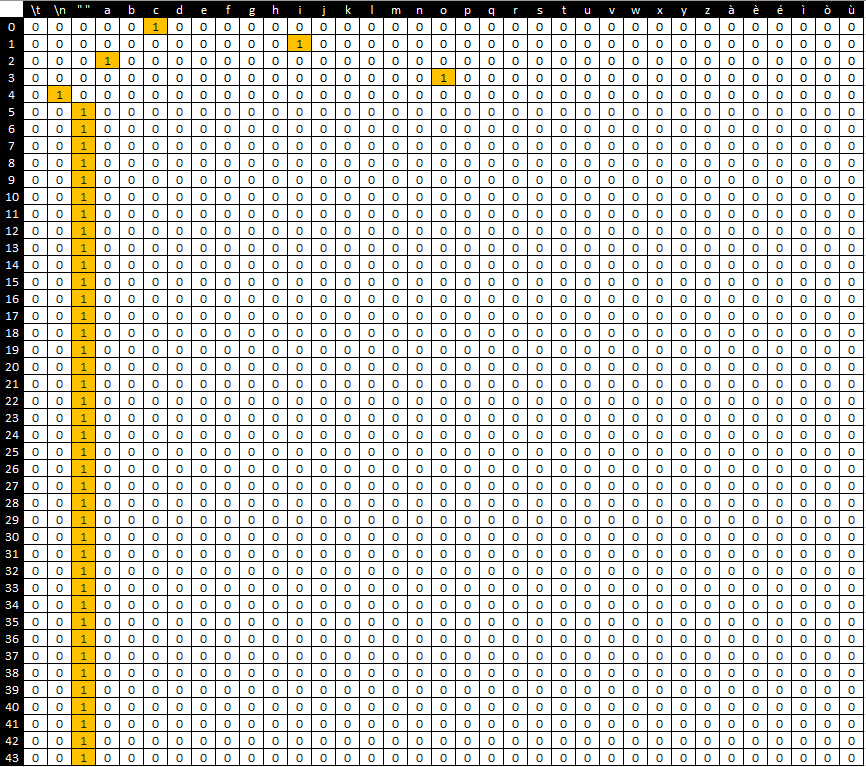 <br>
<br>Target Decoder Input:"parlai\n"<br>
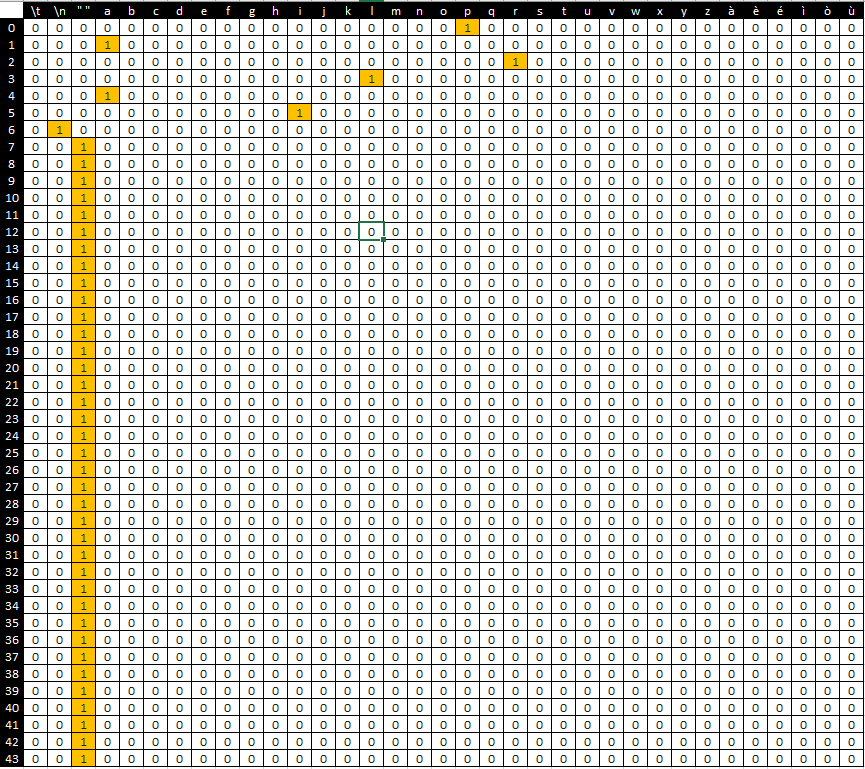